In [61]:
%pip install zss
%pip install lxml
%pip install pandas
%pip install seaborn
%pip install -U sentence-transformers
%pip install gensim
%pip install levenshtein

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.4 MB/s eta 0:00:000:00:01
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 2.3.1
    Uninstalling sentence-transformers-2.3.1:
      Successfully uninstalled sentence-transformers-2.3.1

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.7/103.7 kB 2.3 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.9 MB/s eta 0:00:000:00:010:00:01:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import xml.etree.ElementTree as ET
from zss import simple_distance, distance, Node
import numpy as np
import zss
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import gensim.downloader as api
dataset = api.load("text8")
import pickle

/var/folders/fx/2dlwmb311n9bt5nz3dllsh6m0000gn/T/ipykernel_67834/385204934.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Basic ZSS + Setup

In [2]:

A = (
    Node("f")
        .addkid(Node("a")
            .addkid(Node("h"))
            .addkid(Node("c")
                .addkid(Node("l"))))
        .addkid(Node("e"))
    )
B = (
    Node("f")
        .addkid(Node("a")
            .addkid(Node("d"))
            .addkid(Node("c")
                .addkid(Node("b"))))
        .addkid(Node("e"))
    )

In [3]:
print(simple_distance(A, B, return_operations=True))

(2.0, [<Operation Update>, <Operation Update>, <Operation Match>, <Operation Match>, <Operation Match>, <Operation Match>])


In [4]:
tree = ET.parse("data/AT1/ICS2-01.xml")
# with open("data/AT1/ICS2-01.xml", "r") as f:
#     data = f.read()
root = tree.getroot()[0]
print(root.attrib["refinement"])
print(root[0].text)
print(root[1:len(root)])
print(len(root))

disjunctive
Gathering personal data
[<Element 'node' at 0x28249abb0>, <Element 'node' at 0x28249b100>, <Element 'node' at 0x28249b330>]
4


In [201]:
class AttackNode(object):

    def __init__(self, label, refinement=OR, children = []):
        self.label = label
        self.refinement = refinement
        self.children = children

    @staticmethod
    def get_children(node):
        return node.children

    @staticmethod
    def get_label(node):
        return node.label

    def get_refinement(node):
        return node.refinement

    def addkid(self, node, before=False):
        if before:  
            self.children.insert(0, node)
        else:   
            self.children.append(node)
        return self

    def __str__(self):
        return self.label

def xmlToZSSTree(file):
    tree = ET.parse(file)
    root = tree.getroot()[0]
    ZSSTree = XMLZSSNode(root)
    return ZSSTree
    
def XMLZSSNode(node):
    label = node[0].text
    # print(label)
    refinement = node.attrib["refinement"]
    children = []
    if len(node) > 1:
        xml_children = node[1:len(node)]
        for i in xml_children:
            children.append(XMLZSSNode(i))
    return AttackNode(label, refinement, children)


    

    

<Axes: >

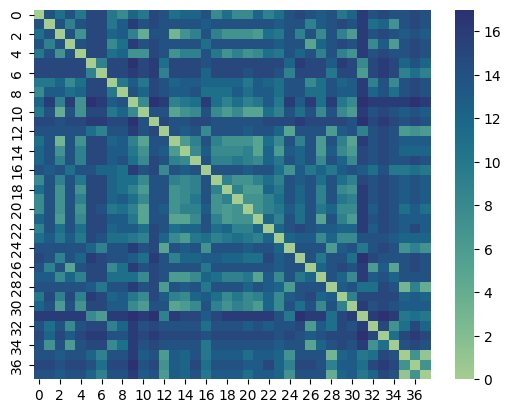

In [6]:


data = []
for i in range(1, 39):
    temp = []
    for j in range(1, 39):
        if i < 10:
            i = "0" + str(i)
        if j < 10:
            j = "0" + str(j)
        T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
        T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
        dist = simple_distance(T1, T2)#, return_operations=True))
        temp.append(dist)
        # print(i, j, dist)
        i = int(i)
        j = int(j)
    data.append(temp)

simple_df = pd.DataFrame(data)
# print(simple_df)        

sns.heatmap(simple_df, annot=False, cmap="crest")

# print(T1, T2)
# print(simple_distance(T1, T2, return_operations=True))

## Simple Distance

12.339971550497866


<Axes: >

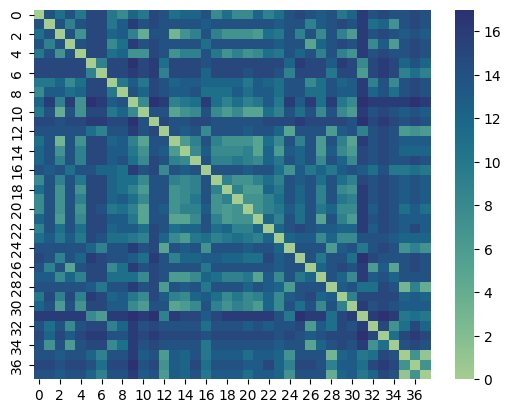

In [33]:
def insert(a):
    return 1
def remove(a):
    return 1
def update(a, b):
    if a == b:
        return 0
    else:
        return 1


data = []
unique = []
for i in range(1, 39):
    temp = []
    for j in range(1, 39):
        if i < 10:
            i = "0" + str(i)
        if j < 10:
            j = "0" + str(j)
        T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
        T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
        dist = distance(T1, T2, Node.get_children, insert, remove, update)
        temp.append(dist)
        if int(i) < int(j):
            unique.append(dist)
        # print(i, j, dist)
        i = int(i)
        j = int(j)
    data.append(temp)

simple_df = pd.DataFrame(data)
# print(simple_df)        

print(sum(unique)/len(unique))
sns.heatmap(simple_df, annot=False, cmap="crest")

## Structual Only

Nodes can be updated at no cost - so the only cost is with adding and subtracting nodes. Hence this is a comparison of construction.

0.9630156472261735


<Axes: >

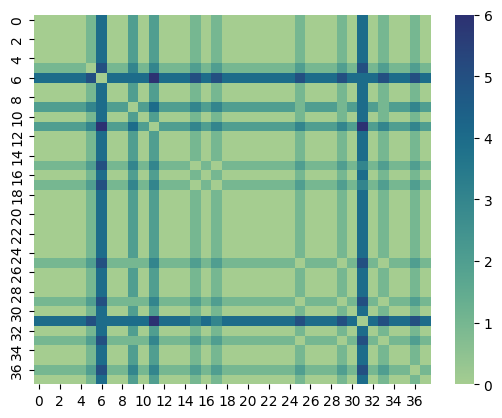

In [94]:
def insert(a):
    return 1
def remove(a):
    return 1
def update(a, b):
    return 0
    if a == b:
        return 0
    else:
        return 1


data = []
unique = []
for i in range(1, 39):
    temp = []
    for j in range(1, 39):
        if i < 10:
            i = "0" + str(i)
        if j < 10:
            j = "0" + str(j)
        T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
        T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
        dist = distance(T1, T2, Node.get_children, insert, remove, update)
        temp.append(dist)
        if int(i) < int(j):
            unique.append(dist)
        # print(i, j, dist)
        i = int(i)
        j = int(j)
    data.append(temp)

simple_df = pd.DataFrame(data)
# print(simple_df)        

print(sum(unique)/len(unique))
sns.heatmap(simple_df, annot=False, cmap="crest")

0.9630156472261735


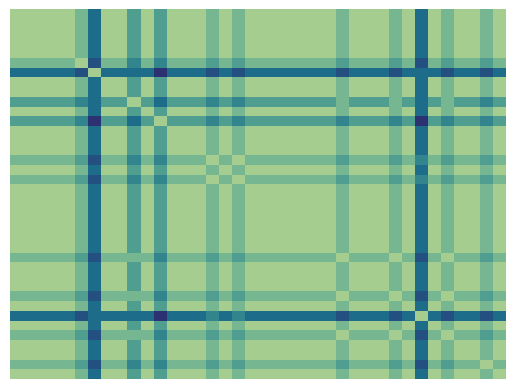

In [61]:
def insert(a):
    return 1
def remove(a):
    return 1
def update(a, b):
    return 0


data = []
unique = []
for i in range(1, 39):
    temp = []
    for j in range(1, 39):
        if i < 10:
            i = "0" + str(i)
        if j < 10:
            j = "0" + str(j)
        T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
        T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
        dist = distance(T1, T2, Node.get_children, insert, remove, update)
        temp.append(dist)
        if int(i) < int(j):
            unique.append(dist)
        # print(i, j, dist)
        i = int(i)
        j = int(j)
    data.append(temp)

print(sum(unique)/len(unique))
simple_df = pd.DataFrame(data)
# print(simple_df)        


ax = sns.heatmap(simple_df, annot=False, cmap="crest",  yticklabels=False,  xticklabels=False, cbar=False)
ax.tick_params(left=False, bottom=False)
plt.savefig("img/test.png")

# Semantic Similarity

In [ ]:
# data = [i for i in dataset]
# def tagged_document(list_of_list_of_words):
#    for i, list_of_words in enumerate(list_of_list_of_words):
#       yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
 
# training_data = list(tagged_document(data))
# model = gensim.models.doc2vec.Doc2Vec(vector_size=40, min_count=2, epochs=30)
 
# model.build_vocab(training_data)
# model.train(training_data, total_examples=model.corpus_count, epochs=model.epochs)

In [289]:
for i in store.keys():
    for j in store[i].keys():
        for k in store[i][j].keys():
            store[i][j][k] = abs(store[i][j][k])

In [58]:

# sentences = [
#     'what is the weather tomorrow',
#     'will it rain tomorrow',
# ]
# embedding = model.encode(sentences, convert_to_tensor=False)
# embedding.shape
# cosine_scores = util.cos_sim(embedding, embedding)
# print(cosine_scores)
# print(float(cosine_scores[0][1]))

# d = {}
# for i, v1 in enumerate(sentences):
#     for j, v2 in enumerate(sentences):
#         if i >= j:
#             continue
#         d[v1 + ' vs. ' + v2] = cosine_scores[i][j].item()

# # sort by score
# d_sorted = dict(sorted(d.items(), key=lambda x: x[1], reverse=True))
# d_sorted


tensor([[1.0000, 0.8253],
        [0.8253, 1.0000]])
0.8252906203269958


{'what is the weather tomorrow vs. will it rain tomorrow': 0.8252906203269958}

In [335]:
from math import sqrt, pow, exp
from sentence_transformers import SentenceTransformer, util
model_key = 'all-MiniLM-L12-v2'
# model_key = 'all-mpnet-base-v2'


 
def squared_sum(x):
  """ return 3 rounded square rooted value """
 
  return round(sqrt(sum([a*a for a in x])),3)
 
def euclidean_distance(x,y):
  """ return euclidean distance between two lists """
 
  return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

def cos_similarity(x,y):
  """ return cosine similarity between two lists """
 
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)



def compare(a, b):
    model = SentenceTransformer(model_key)
    embedding = model.encode([a,b], convert_to_tensor=False)
    cosine_scores = util.cos_sim(embedding, embedding)
    # print(a, b, round(float(float(cosine_scores[0][1])),4))
    return round(float(float(cosine_scores[0][1])),4)
    # vectors = [model.infer_vector([word for word in sent]).reshape(1,-1) for sent in [a, b]]
    # # print(vectors[0])
    # return cos_similarity(vectors[0][0],vectors[1][0])

with open('similarity_store', 'rb') as fp:
    store = pickle.load(fp)
    print(not model_key in store.keys())
    if not model_key in store.keys():
        store[model_key] = {}


# This is just the compare function but all combinations are stored in a massive dictionary - this is to speed up computations for common attack trees
def stored_compare(a, b):
    if a in store[model_key]:
        if b in store[model_key][a]:
            return store[model_key][a][b]
        else:
            embedding = model.encode([a,b], convert_to_tensor=False)
            cosine_scores = util.cos_sim(embedding, embedding)
            store[model_key][a][b] =  round(float(float(cosine_scores[0][1])),4)
            return store[model_key][a][b]    
    else:
        store[model_key][a] = {}
        embedding = model.encode([a,b], convert_to_tensor=False)
        cosine_scores = util.cos_sim(embedding, embedding)
        store[model_key][a][b] =  round(float(float(cosine_scores[0][1])),4)
        return store[model_key][a][b]
    

False


In [331]:
with open('similarity_store', 'wb') as fp:
    pickle.dump(store, fp) 

In [288]:
store.keys()

dict_keys(['paraphrase-multilingual-MiniLM-L12-v2', 'all-mpnet-base-v2', 'all-MiniLM-L12-v2'])

# XML Ingestion

In [355]:
import time

# mks = ['paraphrase-multilingual-MiniLM-L12-v2', 'all-mpnet-base-v2', 'all-MiniLM-L12-v2', "normalized_levenshtein"]
mks = ["normalized_levenshtein"]
lims = []
for i in range(0,10):
    # lims.append(round(.1*i,4))
    for j in range(0,10):
        lims.append(round(.1*i+.01*j, 4))
lims.append(1)
# lims.append(1.001)
    # lims.extend([round(.9 + .01*i, 4) for i in range(0, 7)])
    # lims.extend([round(.96 + .001*i, 4) for i in range(0, 10)])
    # lims.extend([round(.97 + .001*i, 4) for i in range(0, 10)])
    # lims.extend([round(.98 + .001*i, 4) for i in range(0, 10)])
    # lims.extend([round(.99 + .001*i, 4) for i in range(0, 10)])
    # lims.append(1)
    
def insert(a):
    return 1
def remove(a):
    return 1
# lim = .9
# model_key = "normalized_levenshtein"
def update(a, b):
    if model_key == "normalized_levenshtein":
        comp = Levenshtein.distance(a.label, b.label)
        comp = 1 - comp/np.max([len(a.label.replace(" ", "")), len(b.label.replace(" ", ""))])
    else:
        comp = stored_compare(a.label, b.label)
    
    if comp > 1:
        print(a.label, b.label, comp)
    if  comp >= lim:
        return 0
    else:
        return 1

def avg_dist():
    start = time.time()
    data = []
    operations = []
    unique = []
    for i in range(1, 39):
        temp = []
        for j in range(1, 39):
            if k == lims[0]:
                print("Processing: ", i, " & ",j)
            if i < 10:
                i = "0" + str(i)
            if j < 10:
                j = "0" + str(j)
            T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
            T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
            dist, opers = distance(T1, T2, AttackNode.get_children, insert, remove, update, True)
            # dist, opers = simple_distance(T1, T2, AttackNode.get_children, return_operations=True)
            temp.append(dist)
            if int(i) < int(j):
                unique.append(dist)
                #Simplify operations - hopefully improve storage size
                top = []
                for op in opers:
                    if op.type == 0:
                        top.append((op.type, op.arg1.label))
                    elif op.type == 1:
                        top.append((op.type, op.arg2.label))
                    else:
                        top.append((op.type, op.arg1.label, op.arg2.label))
                operations.append((i, j, top))
            # print(i, j, dist)
            i = int(i)
            j = int(j)
        data.append(temp)
    end = time.time()
    print(model_key, lim, end - start, sum(unique)/len(unique))
    simple_df = pd.DataFrame(data)
    return simple_df, operations

# all_data = []
# for k in lims:
#     lim = k
#     simple_df, operations = avg_dist()
#     all_data.append((k, simple_df, operations))
# with open("simpledist", 'wb') as fp:
#     pickle.dump(all_data3, fp) 
    
    
for model_key in mks: 
    all_data3 = []
    for k in lims:
        lim = k
        simple_df, operations = avg_dist()
        all_data3.append((k, simple_df, operations))
        # ax = sns.heatmap(simple_df, annot=False, cmap="crest",  yticklabels=False,  xticklabels=False, cbar=False)
        # ax.tick_params(left=False, bottom=False)
        # plt.savefig("img/sim_dist_heatmaps/lim-"+str(lim)+".png")
    with open(str(len(lims)) + 'lims_mk_' + str(model_key) + "_w_ops", 'wb') as fp:
        pickle.dump(all_data3, fp) 

with open('similarity_store', 'wb') as fp:
    pickle.dump(store, fp) 

# sns.heatmap(simple_df, annot=False, cmap="crest")

Processing:  1  &  1
Processing:  1  &  2
Processing:  1  &  3
Processing:  1  &  4
Processing:  1  &  5
Processing:  1  &  6
Processing:  1  &  7
Processing:  1  &  8
Processing:  1  &  9
Processing:  1  &  10
Processing:  1  &  11
Processing:  1  &  12
Processing:  1  &  13
Processing:  1  &  14
Processing:  1  &  15
Processing:  1  &  16
Processing:  1  &  17
Processing:  1  &  18
Processing:  1  &  19
Processing:  1  &  20
Processing:  1  &  21
Processing:  1  &  22
Processing:  1  &  23
Processing:  1  &  24
Processing:  1  &  25
Processing:  1  &  26
Processing:  1  &  27
Processing:  1  &  28
Processing:  1  &  29
Processing:  1  &  30
Processing:  1  &  31
Processing:  1  &  32
Processing:  1  &  33
Processing:  1  &  34
Processing:  1  &  35
Processing:  1  &  36
Processing:  1  &  37
Processing:  1  &  38
Processing:  2  &  1
Processing:  2  &  2
Processing:  2  &  3
Processing:  2  &  4
Processing:  2  &  5
Processing:  2  &  6
Processing:  2  &  7
Processing:  2  &  8
Proce

## Making Line Plots

In [350]:
# with open('lim991-999', 'rb') as fp:
#     thedata = pickle.load(fp)
# with open('lim90-1', 'rb') as fp:
#     thedata2 = pickle.load(fp)
# thedata.extend(thedata2)all-MiniLM-L12-v2
# print(len(thedata))normalized_levenshtein

with open('1001lims_mk_paraphrase-multilingual-MiniLM-L12-v2', 'rb') as fp:
    d1 = pickle.load(fp)
with open('1001lims_mk_all-mpnet-base-v2', 'rb') as fp:
    d2 = pickle.load(fp)
with open('1001lims_mk_all-MiniLM-L12-v2', 'rb') as fp:
    d3 = pickle.load(fp)
with open('1001lims_mk_normalized_levenshtein', 'rb') as fp:
    d4 = pickle.load(fp)

# try:
#     print(len(d1))
# except:
#     with open('1002lims_mk_paraphrase-multilingual-MiniLM-L12-v2_w_ops', 'rb') as fp:
#         d1 = pickle.load(fp)
#         print("Loaded d1")
# try:
#     print(len(d2))
# except:
#     with open('1002lims_mk_all-mpnet-base-v2_w_ops', 'rb') as fp:
#         d2 = pickle.load(fp)
#         print("Loaded d1")
# try:
#     print(len(d3))
# except:
#     with open('1002lims_mk_all-MiniLM-L12-v2_w_ops', 'rb') as fp:
#         d3 = pickle.load(fp)
#         print("Loaded d1")
# try:
#     print(len(d4))
# except:
#     with open('1002lims_mk_normalized_levenshtein_w_ops', 'rb') as fp:
#         d4 = pickle.load(fp)
#         print("Loaded d1")

def extractUnique(tdf):
    # print(df)
    toRet = []
    for i in range(len(tdf)):
        for j in range(i, len(tdf[i])):
            # print(i, j)
            toRet.append(tdf[i][j])
    return toRet

def makeLine(data):
    tracker = []
    skip1 = True
    for thedata in data: 
        for k in range(len(thedata[1])):
            unique = extractUnique(pd.DataFrame(thedata[1][k][1]))
            # tracker.append((thedata[k][0], min(unique)))
            tracker.append((thedata[1][k][0], thedata[0], sum(unique)/len(unique)))
            # tracker.append((thedata[k][0], max(unique)))
        # # print(tracker)
        # ordered = []
        # ordered.extend(tracker[9:18])
        # ordered.extend(tracker[0:9])
        # ordered.append(tracker[18])
        # # print(ordered)
    # if tracker[-1][0] != 1.001:
    #     tracker.append((1.001, thedata[0], 14.560455192034139))
        # print(tracker)
    tdf = pd.DataFrame(tracker)
    tdf.columns = ["limit", "model", "average distance"]
    # for i in range(0, len(tdf["limit"])):
    #     if len(str(tdf["limit"][i])) == 3:
    #         tdf["limit"][i] = str(tdf["limit"][i]) + "00"
    #     if len(str(tdf["limit"][i])) == 4:
    #         tdf["limit"][i] = s tr(tdf["limit"][i]) + "0"
            # print(i)
            
    # print(tdf)
    return tdf


simple_line = []
for i in range(0, 1003):
    simple_line.append((round(i*.001, 4), 12.339971550497866))
sldf = pd.DataFrame(simple_line)
sldf.columns = ["limit", "average distance"]

In [351]:
ld1 = makeLine([("paraphrase-multilingual-MiniLM-L12-v2_w_ops", d1), ("all-mpnet-base-v2", d2), ("all-MiniLM-L12-v2", d3)])
# ld2 = makeLine(d2)
# ld3 = makeLine(d3)
ld4 = makeLine([("Normalized Levenshtein", d4)])

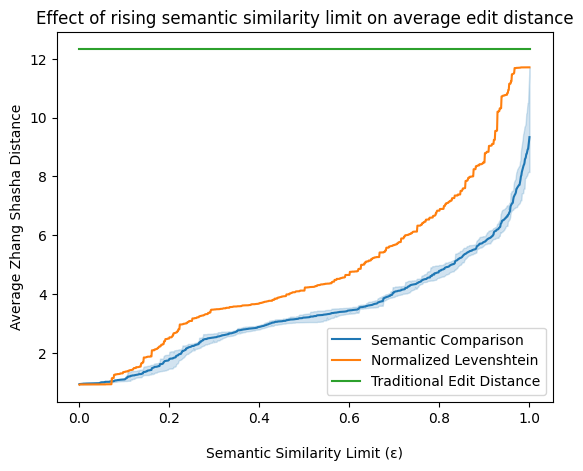

In [352]:
# print(ld2)
sns.lineplot(ld1, x="limit", y ="average distance", label = "Semantic Comparison")
# sns.lineplot(ld2, x="limit", y ="average distance", label = "all-mpnet-base-v2")
# sns.lineplot(ld3, x="limit", y ="average distance", label = "all-MiniLM-L12-v2")
sns.lineplot(ld4, x="limit", y ="average distance", label = "Normalized Levenshtein")
sns.lineplot(sldf, x="limit", y ="average distance", label = "Traditional Edit Distance")

plt.xlabel("\nSemantic Similarity Limit (ε)")
plt.ylabel("Average Zhang Shasha Distance")
# plt.xticks(fontsize=8, rotation=90)
plt.title("Effect of rising semantic similarity limit on average edit distance")    

plt.savefig("img/similaritylimits2.pdf", bbox_inches='tight')

In [92]:
import Levenshtein

Levenshtein.distance("lewenstein", "levenshtein")

def lvs(a, b):
    print(compare(a, b), Levenshtein.distance(a,b))

lvs("obtain personal data", "obtain personnel")
lvs("obtain personal data", "gather private info")
lvs("break open safe", "break open door")
lvs("break open safe", "crack safe open")
lvs("crack safe", "crack door")
lvs("door open", "open door")
# print(compare("obtain personal data", "obtain personnel"))

obtain personal data obtain personnel 0.4507
0.4507 7
obtain personal data gather private info 0.5521
0.5521 15
break open safe break open door 0.7855
0.7855 4
break open safe crack safe open 0.814
0.814 11
crack safe crack door 0.6692
0.6692 4
door open open door 0.992
0.992 8


# Refinement Awareness

In [140]:
#!/usr/bin/env python

import zss
OR = 0
AND = 1

def insert(a):
    return 1
def remove(a):
    return 1
lim = .75
def update(a, b):
    toRet = 0
    # if a.refinement != b.refinement:
    #     toRet += .5
    if compare(a.label, b.label) < lim:
        toRet += 1
    return toRet

def update_g(a, b):
    toRet = 0
    if a.refinement != b.refinement:
        toRet += .5
    if compare(a.label, b.label) < lim:
        toRet += 1
    return toRet

for i in range(1, 39):
    temp = []
    if int(i) < 10:
        i = "0" + str(i)
    for j in range(1, 39):
        # if k == lims[0]:
            # print("Processing: ", i, " & ",j)
        if int(j) < 10:
            j = "0" + str(j)
        T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
        T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
        dist = distance(T1, T2, AttackNode.get_children, insert, remove, update)
        dist2 = distance(T1, T2, AttackNode.get_children, insert, remove, update_g)
        print(i, j, dist, dist2)
# assert dist == 20

01 01 0.0 0.0
01 02 8.0 9.0
01 03 4.0 4.0
01 04 5.0 5.0
01 05 6.0 6.0
01 06 9.0 9.5
01 07 9.0 9.5
01 08 5.0 5.0
01 09 2.0 2.5
01 10 7.0 7.0
01 11 5.0 5.0
01 12 14.0 15.0
01 13 5.0 5.0
01 14 5.0 5.0
01 15 5.0 5.0
01 16 3.0 3.0
01 17 5.0 5.0
01 18 2.0 2.0
01 19 4.0 4.0
01 20 1.0 1.0
01 21 4.0 4.0
01 22 5.0 5.0
01 23 8.0 8.0


KeyboardInterrupt: 

# Node Flipping

In [213]:
def SemanticFlipping(T1, T2):
    M = [(T1,T2)]
    for m in M:
        print(m[0].label, m[1].label)
        D = np.zeros((len(m[0].children), len(m[1].children)))
        # print(D)
        for i, c1 in enumerate(m[0].children):
            for j, c2 in enumerate(m[1].children):
                D[i][j] = stored_compare(c1.label, c2.label)
        # print(D, type(D), np.max(D), np.where(D==np.max(D)))
        # print(np.where(D==np.max(D))[0][0], np.where(D==np.max(D))[1][0])
        M_t = []
        nc1 = []
        nc2 = []
        print(m[0].children)
        while D.size != 0:
            max = np.max(D)
            row = np.where(D==np.max(D))[0][0]
            col = np.where(D==np.max(D))[1][0]
            # print(D, max, row, col)
            M_t.append((m[0].children[row], m[1].children[col]))
            nc1.append(m[0].children[row])
            nc2.append(m[1].children[col])
            m[0].children.remove(m[0].children[row])
            m[1].children.remove(m[1].children[col])
            D = np.delete(D, row, 0)
            D = np.delete(D, col, 1)
    
        nc1.extend(m[0].children)
        nc2.extend(m[1].children)
        m[0].children = nc1.copy()
        m[1].children = nc2.copy()
        print(m[0].children)
        
        # print(M_t)
        M.extend(M_t)
    return T1, T2, M



# Handling Operations

In [7]:
# i = 10
# j = 11
# lim = 1.001
# T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
# T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
# dist, Test = distance(T1, T2, AttackNode.get_children, insert, remove, update, True)
# print(Test)
# for i, op in enumerate(Test):
#     if op.type == 0:
#         print(str(i) + ") Removing: "+ op.arg1.label)
#     elif op.type == 1:
#         print(str(i) + ") Adding: "+ op.arg2.label)
#     elif op.type == 2:
#         print(str(i) + ") Changing: "+ op.arg1.label + " --> " + op.arg2.label)
#     elif op.type == 3:
#         print(str(i) + ") Matching: "+ op.arg1.label + " == " + op.arg2.label)

def enumerate_operations(ops):
    for i, op in enumerate(ops):
        if op.type == 0:
            print(str(i) + ") Removing: "+ op.arg1.label)
        elif op.type == 1:
            print(str(i) + ") Adding: "+ op.arg2.label)
        elif op.type == 2:
            print(str(i) + ") Changing: "+ op.arg1.label + " --> " + op.arg2.label)
        elif op.type == 3:
            print(str(i) + ") Matching: "+ op.arg1.label + " == " + op.arg2.label)

def count_operations(ops):
    count = {0:0, 1:0, 2:0, 3:0}
    for op in ops:
        op = op[2] # Operations are enumerated as lists nested in tuples
        # print(op)
        for i in op:
            count[i[0]] += 1
    return count



# def changed_operation(ops):
#     changed = {}
#     for op in ops:
#         op = op[2] # Operations are enumerated as lists nested in tuples
#         for i in op:
#             if i.type == 2:
#                 args = [i[1], i[2]]
#                 args.sort()
#                 if not args[0] in changed.keys():
#                     changed[args[0]] = {}
#                 changed[args[0]][args[1]]
                
with open('101lims_mk_normalized_levenshtein_w_ops', 'rb') as fp:
    d1 = pickle.load(fp)
    print(len(d1))
for i in d1:
    print(i[0], count_operations(i[2]))



101
0.0 {0: 312, 1: 405, 2: 93, 3: 9446}
0.01 {0: 398, 1: 491, 2: 235, 3: 9218}
0.02 {0: 398, 1: 491, 2: 235, 3: 9218}
0.03 {0: 400, 1: 492, 2: 266, 3: 9185}
0.04 {0: 418, 1: 510, 2: 254, 3: 9179}
0.05 {0: 421, 1: 512, 2: 292, 3: 9138}
0.06 {0: 442, 1: 533, 2: 408, 3: 9001}
0.07 {0: 469, 1: 560, 2: 408, 3: 8974}
0.08 {0: 499, 1: 593, 2: 491, 3: 8856}
0.09 {0: 618, 1: 723, 2: 394, 3: 8816}
0.1 {0: 635, 1: 729, 2: 464, 3: 8740}
0.11 {0: 665, 1: 756, 2: 454, 3: 8706}
0.12 {0: 706, 1: 785, 2: 499, 3: 8641}
0.13 {0: 778, 1: 844, 2: 453, 3: 8615}
0.14 {0: 802, 1: 869, 2: 504, 3: 8531}
0.15 {0: 810, 1: 876, 2: 558, 3: 8469}
0.16 {0: 806, 1: 844, 2: 624, 3: 8409}
0.17 {0: 810, 1: 839, 2: 653, 3: 8376}
0.18 {0: 792, 1: 821, 2: 707, 3: 8341}
0.19 {0: 827, 1: 805, 2: 683, 3: 8323}
0.2 {0: 857, 1: 798, 2: 663, 3: 8314}
0.21 {0: 857, 1: 798, 2: 667, 3: 8310}
0.22 {0: 860, 1: 791, 2: 697, 3: 8273}
0.23 {0: 992, 1: 879, 2: 491, 3: 8339}
0.24 {0: 990, 1: 877, 2: 498, 3: 8334}
0.25 {0: 990, 1: 877, 2: 

In [290]:
print(store.keys())
mk = "paraphrase-multilingual-MiniLM-L12-v2"
for i in store[mk].keys():
    for j in store[mk][i].keys():
         if store[mk][i][j] < 0:
            print(i, j, store[mk][i][j])
        # print(store["all-MiniLM-L12-v2"][i][j])


dict_keys(['paraphrase-multilingual-MiniLM-L12-v2', 'all-mpnet-base-v2', 'all-MiniLM-L12-v2'])
